In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# from lightgbm import LGBMClassifier
import xgboost as xgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('modeling_data.csv') 
data.head()

,Unnamed: 0,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,event_cutoff_by,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,...,mode_event_os,minutes_of_first_event_and_window_end,cutoff_amount,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order
0,0,500245685,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-23 11:02:29.219700000,G111,48 Hours,Monday,7,OFS,...,Windows,5924.706600,1777.411980,7,5,0,0,1,0,0
1,1,500245685,2025-03-17 17:00:00,2025-03-24 17:00:00,2025-03-22 19:49:23.863200000,G111,48 Hours,Monday,7,OFS,...,Windows,9034.144367,2710.243310,2,0,0,0,0,0,0
2,2,500245685,2025-04-14 17:00:00,2025-04-21 17:00:00,2025-04-20 11:20:52.683900000,G111,48 Hours,Monday,7,OFS,...,Windows,5927.056417,1778.116925,3,1,0,0,1,0,0
3,3,500245685,2025-04-28 17:00:00,2025-05-05 17:00:00,2025-05-04 18:24:35.996400000,G111,48 Hours,Monday,7,OFS,...,Windows,4507.125967,1352.137790,2,0,0,0,0,0,0
4,4,500245738,2024-11-20 17:00:00,2024-11-27 17:00:00,2024-11-26 03:25:05.337600000,G111,48 Hours,Wednesday,7,OFS,...,Windows,7515.126033,2254.537810,2,0,0,1,0,0,1


In [5]:
x = data.drop(columns=['ABANDONED_CART','CUSTOMER_ID'])
y = data['ABANDONED_CART']

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.3,
    random_state=12345,
    stratify=y 
)

# Logistic

In [6]:
import pandas as pd

# Example: your training data
x_train = x_train.copy()

# Identify datetime-like columns
dt_cols = x_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns

# Convert datetime columns to numeric (days since min date per column)
for c in dt_cols:
    # Ensure all are parsed as datetimes
    x_train[c] = pd.to_datetime(x_train[c], errors='coerce')

    # Choose a reference (anchor) — earliest date in train
    anchor = x_train[c].min()

    # Convert to days since anchor
    x_train[c] = (x_train[c] - anchor).dt.total_seconds() / 86400.0  # seconds → days

# Repeat the same transformation for x_test using the same anchor values
for c in dt_cols:
    x_test[c] = pd.to_datetime(x_test[c], errors='coerce')
    x_test[c] = (x_test[c] - anchor).dt.total_seconds() / 86400.0


Accuracy : 0.8887
Precision: 0.7342
Recall   : 0.3505
F1 Score : 0.4745
AUC      : 0.8331

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.98      0.94      4759
         1.0       0.73      0.35      0.47       796

    accuracy                           0.89      5555
   macro avg       0.82      0.66      0.71      5555
weighted avg       0.88      0.89      0.87      5555


Confusion Matrix (counts):
 [[4658  101]
 [ 517  279]]

Confusion Matrix (proportions by true class):
 [[0.979 0.021]
 [0.649 0.351]]


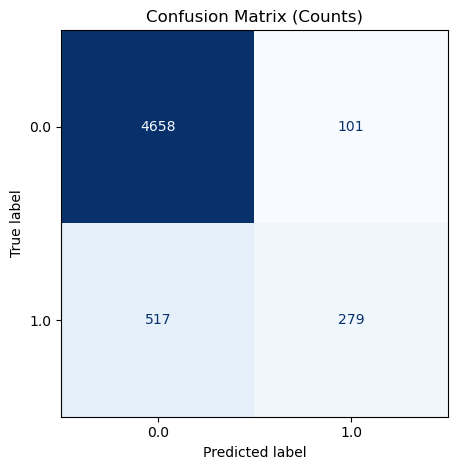

In [9]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 1) One-hot encode any remaining non-numeric columns
x_train_enc = pd.get_dummies(x_train, drop_first=True)
x_test_enc  = pd.get_dummies(x_test,  drop_first=True)

# 2) Align columns (ensure same features in train & test)
x_test_enc = x_test_enc.reindex(columns=x_train_enc.columns, fill_value=np.nan)

# 3) Simple impute: fill NaNs with train medians
medians = x_train_enc.median(numeric_only=True)
x_train_enc = x_train_enc.fillna(medians)
x_test_enc  = x_test_enc.fillna(medians)

# 4) Fit logistic regression
model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
model.fit(x_train_enc, y_train)

# 5) Predict
y_pred  = model.predict(x_test_enc)
y_proba = model.predict_proba(x_test_enc)[:, 1]

# 6) Metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_proba)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# 7) Confusion matrix (counts + normalized)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix (counts):\n", cm)

cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
print("\nConfusion Matrix (proportions by true class):\n", np.round(cm_norm, 3))

# Optional: plot counts matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title('Confusion Matrix (Counts)')
plt.tight_layout()
plt.show()


# Random forest

In [12]:
# ===== Imports =====
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report, make_scorer
)

# ===== Assumes you already have x_train, x_test, y_train, y_test =====
# If not, uncomment the split lines below (expects `data` with ABANDONED_CART target):
# X = data.drop(columns=['ABANDONED_CART','CUSTOMER_ID'])
# y = data['ABANDONED_CART']
# x_train, x_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.30, random_state=12345, stratify=y
# )

# --- 1) One-hot encode categoricals, align columns, simple median impute ---
x_train_enc = pd.get_dummies(x_train, drop_first=True)
x_test_enc  = pd.get_dummies(x_test,  drop_first=True)
x_test_enc  = x_test_enc.reindex(columns=x_train_enc.columns, fill_value=np.nan)
medians = x_train_enc.median(numeric_only=True)
x_train_enc = x_train_enc.fillna(medians)
x_test_enc  = x_test_enc.fillna(medians)

# --- 2) Baseline RF (no tuning) ---
rf_base = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_base.fit(x_train_enc, y_train)
y_proba_base = rf_base.predict_proba(x_test_enc)[:, 1]

# --- 3) Grid search for best recall ---
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [None, 12, 20],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': [None, 'balanced_subsample', 'balanced']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=make_scorer(recall_score),   # optimize recall
    cv=cv,
    n_jobs=-1,
    verbose=1
)
gs.fit(x_train_enc, y_train)

best_rf = gs.best_estimator_
y_proba_best = best_rf.predict_proba(x_test_enc)[:, 1]

print("Best params:", gs.best_params_)
print("CV best recall:", round(gs.best_score_, 4))

# --- 4) Choose thresholds for evaluation ---
# Always evaluate at default 0.50
th_default = 0.50

# Also pick threshold that maximizes F2 (recall-heavy)
ths = np.linspace(0.01, 0.99, 99)
f2_vals = []
for th in ths:
    y_pred_th = (y_proba_best >= th).astype(int)
    f2_vals.append(fbeta_score(y_test, y_pred_th, beta=2.0, zero_division=0))
th_f2_opt = ths[int(np.argmax(f2_vals))]

print(f"Chosen F2-optimal threshold for best RF: {th_f2_opt:.3f}")

# --- 5) Utility to compute metrics & confusion counts at a threshold ---
def eval_metrics(y_true, y_proba, th, label):
    y_pred = (y_proba >= th).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_proba)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "Model@Threshold": label,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp
    }

# --- 6) Build comparison table ---
rows = []
# Baseline RF @ 0.50
rows.append(eval_metrics(y_test, y_proba_base, th_default, "BaselineRF@0.50"))

# Best RF @ 0.50
rows.append(eval_metrics(y_test, y_proba_best, th_default, "BestRF@0.50"))

# Best RF @ F2-opt
rows.append(eval_metrics(y_test, y_proba_best, th_f2_opt, f"BestRF@F2opt({th_f2_opt:.2f})"))

results_df = pd.DataFrame(rows)
# Nicely formatted view
metrics_cols = ["Model@Threshold", "Accuracy", "Precision", "Recall", "F1", "AUC", "TN", "FP", "FN", "TP"]
results_df = results_df[metrics_cols]
print("\n=== Comparison Table ===")
print(results_df.to_string(index=False))

# --- 7) (Optional) Detailed classification report for the chosen setting ---
# Pick your preferred row (e.g., F2-opt) to inspect:
chosen_th = th_f2_opt
y_pred_chosen = (y_proba_best >= chosen_th).astype(int)
print("\nClassification report for BestRF at chosen threshold:")
print(classification_report(y_test, y_pred_chosen, zero_division=0))

# --- 8) (Optional) Show ROC AUC curves quickly (no plot libs required) ---
# If you want the ROC curve visually, you can add matplotlib plotting.


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best params: {'class_weight': 'balanced_subsample', 'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 500}
CV best recall: 0.3536
Chosen F2-optimal threshold for best RF: 0.330

=== Comparison Table ===
   Model@Threshold  Accuracy  Precision   Recall       F1      AUC   TN   FP  FN  TP
   BaselineRF@0.50  0.878308   0.833333 0.188442 0.307377 0.796287 4729   30 646 150
       BestRF@0.50  0.861926   0.525573 0.374372 0.437271 0.778746 4490  269 498 298
BestRF@F2opt(0.33)  0.576418   0.230343 0.835427 0.361119 0.778746 2537 2222 131 665

Classification report for BestRF at chosen threshold:
              precision    recall  f1-score   support

         0.0       0.95      0.53      0.68      4759
         1.0       0.23      0.84      0.36       796

    accuracy                           0.58      5555
   macro avg       0.59      0.68      0.52      5555
weighted avg       0.85      0.58      0.64      5555



In [ ]:
# ===== XGBoost (core API) with early stopping + threshold tuning =====
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# ---- 0) One-hot encode & align (uses your existing x_train/x_test) ----
x_train_enc = pd.get_dummies(x_train, drop_first=True)
x_test_enc  = pd.get_dummies(x_test,  drop_first=True)
x_test_enc  = x_test_enc.reindex(columns=x_train_enc.columns, fill_value=np.nan)

# (Optional) Simple impute (XGB can handle NaNs, but this is explicit)
medians = x_train_enc.median(numeric_only=True)
x_train_enc = x_train_enc.fillna(medians)
x_test_enc  = x_test_enc.fillna(medians)

# ---- 1) Wrap in DMatrix ----
dtrain = xgb.DMatrix(x_train_enc, label=y_train, feature_names=x_train_enc.columns.tolist())
dvalid = xgb.DMatrix(x_test_enc,  label=y_test,  feature_names=x_test_enc.columns.tolist())

# ---- 2) Class imbalance weight ----
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw = neg / max(pos, 1)

# ---- 3) Train with early stopping (AUC) ----
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.03,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,             # L2
    "alpha": 0.0,              # L1
    "scale_pos_weight": spw,   # handle imbalance
    "tree_method": "hist",
    "seed": 42,
}
watchlist = [(dtrain, "train"), (dvalid, "valid")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False,
)

# ---- 4) Predict using best_iteration (works on new XGB) ----
best_iter = getattr(bst, "best_iteration", None)
if best_iter is not None:
    y_proba = bst.predict(dvalid, iteration_range=(0, best_iter + 1))
else:
    y_proba = bst.predict(dvalid)

# Helper to print metrics neatly
def show_metrics(y_true, y_pred, y_prob, label):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"\n=== {label} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"CM -> TN:{tn} FP:{fp} FN:{fn} TP:{tp}")

# ---- 5) Metrics at default 0.50 ----
y_pred_050 = (y_proba >= 0.50).astype(int)
show_metrics(y_test, y_pred_050, y_proba, "XGB (core) @ 0.50")

# ---- 6) Threshold sweep: maximize accuracy with recall >= 0.70 ----
def sweep_thresholds(y_true, y_prob, thresholds):
    rows = []
    for th in thresholds:
        yp = (y_prob >= th).astype(int)
        acc  = accuracy_score(y_true, yp)
        prec = precision_score(y_true, yp, zero_division=0)
        rec  = recall_score(y_true, yp, zero_division=0)
        f1   = f1_score(y_true, yp, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        rows.append({"th": th, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
                     "tn": tn, "fp": fp, "fn": fn, "tp": tp})
    return pd.DataFrame(rows)

grid = np.linspace(0.05, 0.95, 91)
th_df = sweep_thresholds(y_test, y_proba, grid)

target_recall = 0.70
candidates = th_df[th_df["recall"] >= target_recall]
best_row = candidates.sort_values("accuracy", ascending=False).iloc[0] if not candidates.empty \
           else th_df.sort_values("recall", ascending=False).iloc[0]
best_th = float(best_row["th"])

print("\nChosen threshold (max accuracy with recall ≥ {:.2f}): {:.3f}".format(target_recall, best_th))
print(best_row[["accuracy","precision","recall","f1","tn","fp","fn","tp"]])

# ---- 7) Metrics at chosen threshold ----
y_pred_best = (y_proba >= best_th).astype(int)
show_metrics(y_test, y_pred_best, y_proba, f"XGB (core) @ {best_th:.3f}")
print("\nClassification report at chosen threshold:\n",
      classification_report(y_test, y_pred_best, zero_division=0))

# ---- 8) Top 20 features (by gain) ----
score = bst.get_score(importance_type="gain")
imp = (pd.DataFrame({"feature": list(score.keys()), "gain": list(score.values())})
       .sort_values("gain", ascending=False)
       .head(20))
print("\nTop 20 XGB features by gain:")
print(imp.to_string(index=False))


In [6]:
# ===== XGBoost (core API) with early stopping, robust across versions =====
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# --- One-hot encode & align (reuse your existing split) ---
x_train_enc = pd.get_dummies(x_train, drop_first=True)
x_test_enc  = pd.get_dummies(x_test,  drop_first=True)
x_test_enc  = x_test_enc.reindex(columns=x_train_enc.columns, fill_value=np.nan)

# Optional impute (XGBoost can handle NaN, but we can be explicit)
medians = x_train_enc.median(numeric_only=True)
x_train_enc = x_train_enc.fillna(medians)
x_test_enc  = x_test_enc.fillna(medians)

# --- DMatrix conversion (faster + stable API) ---
dtrain = xgb.DMatrix(x_train_enc, label=y_train, feature_names=x_train_enc.columns.tolist())
dvalid = xgb.DMatrix(x_test_enc,  label=y_test,  feature_names=x_test_enc.columns.tolist())

# --- Imbalance weight ---
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw = neg / max(pos, 1)

# --- Params (AUC early stopping on valid) ---
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.03,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,      # L2
    "alpha": 0.0,       # L1
    "scale_pos_weight": spw,
    "tree_method": "hist",
    "seed": 42,
}

watchlist = [(dtrain, "train"), (dvalid, "valid")]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False,
)

# --- Predictions/probabilities (use best_ntree_limit) ---
y_proba = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)
y_pred_050 = (y_proba >= 0.50).astype(int)

def show_metrics(y_true, y_pred, y_prob, label):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"\n=== {label} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1       : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"CM -> TN:{tn} FP:{fp} FN:{fn} TP:{tp}")

show_metrics(y_test, y_pred_050, y_proba, "XGB (core) @ 0.50")

# --- Threshold sweep: maximize accuracy with recall >= 0.70 ---
def sweep_thresholds(y_true, y_prob, thresholds):
    rows = []
    for th in thresholds:
        yp = (y_prob >= th).astype(int)
        acc  = accuracy_score(y_true, yp)
        prec = precision_score(y_true, yp, zero_division=0)
        rec  = recall_score(y_true, yp, zero_division=0)
        f1   = f1_score(y_true, yp, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        rows.append({"th": th, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
                     "tn": tn, "fp": fp, "fn": fn, "tp": tp})
    return pd.DataFrame(rows)

grid = np.linspace(0.05, 0.95, 91)
th_df = sweep_thresholds(y_test, y_proba, grid)

target_recall = 0.70
candidates = th_df[th_df["recall"] >= target_recall]
best_row = candidates.sort_values("accuracy", ascending=False).iloc[0] if not candidates.empty \
           else th_df.sort_values("recall", ascending=False).iloc[0]
best_th = float(best_row["th"])

print("\nChosen threshold (max accuracy with recall ≥ {:.2f}): {:.3f}".format(target_recall, best_th))
print(best_row[["accuracy","precision","recall","f1","tn","fp","fn","tp"]])

# --- Metrics at chosen threshold ---
y_pred_best = (y_proba >= best_th).astype(int)
show_metrics(y_test, y_pred_best, y_proba, f"XGB (core) @ {best_th:.3f}")
print("\nClassification report at chosen threshold:\n",
      classification_report(y_test, y_pred_best, zero_division=0))

# --- Top features ---
# get_score returns dict of {feature_name: importance}; convert to DataFrame
score = bst.get_score(importance_type="gain")
imp = (pd.DataFrame({"feature": list(score.keys()), "gain": list(score.values())})
       .sort_values("gain", ascending=False)
       .head(20))
print("\nTop 20 XGB features by gain:")
print(imp.to_string(index=False))


AttributeError: 'Booster' object has no attribute 'best_ntree_limit'